In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from scipy.spatial.distance import squareform

In [2]:
path = '/Users/fbickfordsmith/Google Drive/Project/attention/'
path_baseline = f'{path}results/baseline_classwise_acc.csv'
path_synsets = f'{path}metadata/synsets.txt'
path_activations = f'{path}activations/activations_mean.npy'

In [3]:
df_baseline = pd.read_csv(path_baseline, index_col=0)
wnids = open(path_synsets).read().splitlines()
wnid2ind = {wnid:ind for ind, wnid in enumerate(wnids)}
X = np.load(path_activations)

In [4]:
def context_size(type_context):
    with open(f'{path}contexts/{type_context}contexts_wnids.csv') as f:
        contexts = [row for row in csv.reader(f, delimiter=',')]
    return [len(c) for c in contexts]

def context_baseline_accuracy(type_context):
    with open(f'{path}contexts/{type_context}contexts_wnids.csv') as f:
        contexts = [row for row in csv.reader(f, delimiter=',')]
    stats = []
    for c in contexts:
        inds_in = [wnid2ind[w] for w in c]
        inds_out = list(set(range(1000)) - set(inds_in))
        stats.append([
            np.mean(df_baseline['accuracy'][inds_in]),
            np.mean(df_baseline['accuracy'][inds_out])])
    return pd.DataFrame(stats, columns=('incontext_base', 'outofcontext_base'))

def average_distance(Xdist):
    if Xdist.shape == (1, 1):
        return 0
    else:
        return np.mean(squareform(Xdist, checks=False))

def context_distance(type_context, measure='euclidean'):
    with open(f'{path}contexts/{type_context}contexts_wnids.csv') as f:
        contexts = [row for row in csv.reader(f, delimiter=',')]

    if measure == 'euclidean':
        distance = euclidean_distances
    else:
        distance = cosine_distances
    
    stats = []
    for c in contexts:
        inds_in = [wnid2ind[w] for w in c]
        stats.append(average_distance(distance(X[inds_in])))

    return pd.Series(stats, name=f'mean_{measure}_distance')

In [5]:
context_size('size')

[1, 2, 4, 8, 16, 32, 64, 128, 256]

In [6]:
df0 = context_baseline_accuracy('size')
df0

,incontext_base,outofcontext_base
0,0.660000,0.646121
1,0.650000,0.646127
2,0.685707,0.645976
3,0.664634,0.645986
4,0.671334,0.645725
5,0.658227,0.645735
6,0.662271,0.645032
7,0.663694,0.643558
8,0.656843,0.642451


In [7]:
df1 = pd.read_csv(f'{path}results/sizecontexts_trained_metrics.csv', index_col=0)
df1

,incontext_loss,incontext_acc_top1,incontext_acc_top5,outofcontext_loss,outofcontext_acc_top1,outofcontext_acc_top5
0,0.692736,0.800000,0.960000,1.513886,0.642421,0.854839
1,0.721023,0.840000,0.930000,1.538555,0.636026,0.852154
2,0.397371,0.895288,0.984293,1.632216,0.617000,0.840718
3,0.571786,0.890863,0.959391,1.846502,0.581055,0.820166
4,0.480532,0.903394,0.964752,2.238949,0.518306,0.779049
5,0.638553,0.847840,0.953578,2.292889,0.495406,0.769379
6,0.832527,0.807429,0.928967,2.085719,0.527618,0.794549
7,1.126315,0.727816,0.903022,1.592861,0.620294,0.848161
8,1.231286,0.708441,0.890625,1.581649,0.620178,0.851125


In [8]:
plt.style.available
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [9]:
scatter_styles = {
    'in': dict(label='in context'),#, marker='o', facecolors='none', edgecolors='b'),
    'out': dict(label='out of context')}#, facecolors='none', edgecolors='r')}#marker='x', facecolors='k')}

In [10]:
plt.style.use('seaborn-bright')

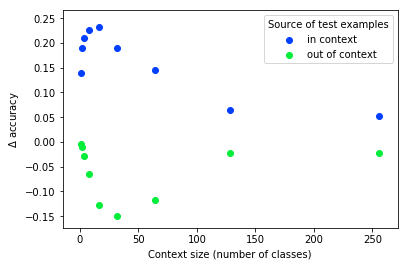

In [11]:
# fig = plt.figure()
plt.scatter(context_size('size'), df1['incontext_acc_top1']-df0['incontext_base'], **scatter_styles['in'])
plt.scatter(context_size('size'), df1['outofcontext_acc_top1']-df0['outofcontext_base'], **scatter_styles['out'])
plt.legend(title='Source of test examples')
plt.xlabel('Context size (number of classes)')
plt.ylabel(r'$\Delta$ accuracy')
plt.show()